In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import pyaudio

In [3]:
model = tf.keras.models.load_model('simple_audio_model.sav')
print('loaded saved model.')
print(model.summary())

loaded saved model.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 

## Get Audio Input

In [8]:
# get pyaudio input device
def getInputDevice(p):
    index = None
    nDevices = p.get_device_count()
    print('Found %d devices:' % nDevices)
    for i in range(nDevices):
        deviceInfo = p.get_device_info_by_index(i)
        #print(deviceInfo)
        devName = deviceInfo['name']
        print(devName)
        # look for the "input" keyword
        # choose the first such device as input
        # change this loop to modify this behavior
        # maybe you want "mic"?
        if not index:
            if 'input' in devName.lower():
                index = i
    # print out chosen device
    if index is not None:
        devName = p.get_device_info_by_index(index)["name"]
        #print("Input device chosen: %s" % devName)
    return index

In [9]:
# initialize pyaudio
p = pyaudio.PyAudio()
getInputDevice(p)

Found 8 devices:
HDA NVidia: HDMI 0 (hw:0,3)
HDA NVidia: HDMI 1 (hw:0,7)
HD-Audio Generic: ALC887-VD Analog (hw:1,0)
HD-Audio Generic: ALC887-VD Digital (hw:1,1)
HD-Audio Generic: ALC887-VD Alt Analog (hw:1,2)
hdmi
pulse
default


Now let's try plotting 1 second of Mic Input

In [10]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

opening stream...
<class 'bytes'>
tf.Tensor([0.         0.         0.         ... 0.0151062  0.01574707 0.01403809], shape=(16000,), dtype=float32)
(124, 129)


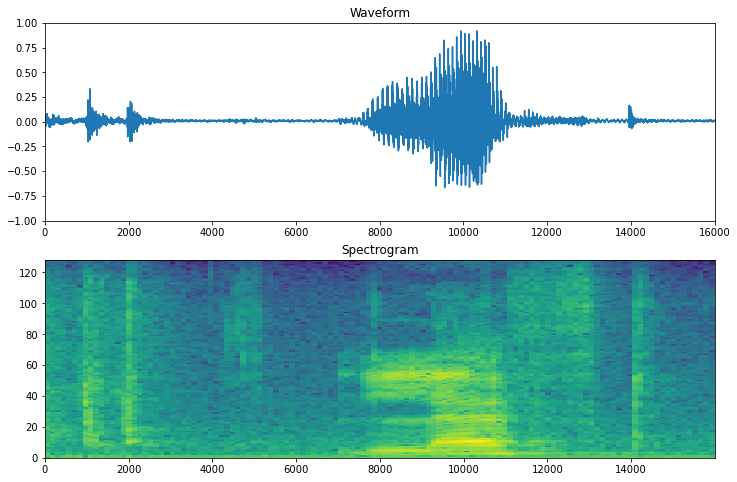

In [93]:
# set sample rate
NSEC = 1
sampleRate = 16000 # #48000
sampleLen = NSEC*sampleRate

print('opening stream...')
stream = p.open(format = pyaudio.paInt16,
                channels = 1,
                rate = sampleRate,
                input = True,
                frames_per_buffer = 4096,
                input_device_index = -1)
# read a chunk of data - discard first
data  = stream.read(sampleLen)
print(type(data))

waveform = tf.cast(tf.io.decode_raw(data, "int16"), "float32")/32768.0
print(waveform)

spectrogram = get_spectrogram(waveform)

#spectrogram = tf.reshape(spectrogram, (spectrogram.shape[0], spectrogram.shape[1], 1))
print(spectrogram.shape)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
axes[0].set_ylim([-1, 1])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [94]:
commands = ['go', 'down', 'up', 'stop', 'yes', 'left', 'right', 'no']
print(spectrogram.shape)

spectrogram1= tf.reshape(spectrogram, (-1, spectrogram.shape[0], spectrogram.shape[1], 1))
print(spectrogram1.shape)

prediction = model(spectrogram1)
print(prediction)
sm = tf.nn.softmax(prediction[0])
am = tf.math.argmax(sm)
print(sm)
print(commands[am])
#plt.bar(commands, tf.nn.softmax(prediction[0]))
#plt.title(f'Predictions for "{commands[label[0]]}"')
#plt.show()

(124, 129)
(1, 124, 129, 1)
tf.Tensor(
[[ -5.365771   -5.005242   -9.055752   -6.305754    7.770034    8.756244
  -13.840996    3.6955895]], shape=(1, 8), dtype=float32)
tf.Tensor(
[5.3360293e-07 7.6523344e-07 1.3325382e-08 2.0844362e-07 2.7041197e-01
 7.2498900e-01 1.1129473e-10 4.5974525e-03], shape=(8,), dtype=float32)
left
